**Import Packages**

In [ ]:
!pip install torch torchvision torchaudio torcheval
!pip install pillow wandb
!pip install cjm_pil_utils cjm_kaggle_utils cjm_pytorch_utils cjm_pandas_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.2 MB/s eta 0:00:00


In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.4 MB/s eta 0:00:00


In [ ]:
!pip install -U "ray[tune]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 14.1 MB/s eta 0:00:00


In [ ]:
from pathlib import Path
import hashlib
import json
import random
import multiprocessing
import math
import os
from functools import partial
from copy import copy
from glob import glob

from PIL import Image
import numpy as np
import timm
from tqdm.auto import tqdm

# Import pandas module for data manipulation
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PyTorch dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
#from torcheval.tools import get_module_summary
from torcheval.metrics import MulticlassAccuracy

# Import miniai dependencies
import fastcore.all as fc
'''
from miniai.datasets import DataLoaders
from miniai.conv import def_device
from miniai.learner import *
from miniai.activations import Hook, ActivationStats
from miniai.accel import MixedPrecision, AccelerateCB
from miniai.init import BatchTransformCB, GeneralRelu, init_weights, set_seed, conv
from miniai.sgd import BatchSchedCB
from miniai.resnet import ResBlock
'''
# Import utility functions
from cjm_kaggle_utils.core import save_kaggle_creds, dl_kaggle
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, tensor_stats_df, get_torch_device, denorm_img_tensor
from cjm_pandas_utils.core import markdown_to_pandas

In [ ]:
import ray
from ray import tune
from ray import train

In [ ]:
username = "kerrtan"
key = "5afd657f4209431584e52070f9c7b418"
save_kaggle_creds(username, key, overwrite=False)

**Data Retrival from Kaggle**

In [ ]:
# Define path to store datasets
dataset_dir = Path("/mnt/980_1TB_2/Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)
print(f"Dataset Directory: {dataset_dir}")

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)
print(f"Archive Directory: {archive_dir}")

Dataset Directory: /mnt/980_1TB_2/Datasets
Archive Directory: /mnt/980_1TB_2/Datasets/../Archive


In [ ]:
# Set the name of the dataset
dataset_name = 'hagrid-classification-512p-no-gesture-150k'

# Construct the Kaggle dataset name by combining the username and dataset name
kaggle_dataset = f'innominate817/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')
print(f"Archive Path: {archive_path}")

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')
print(f"Dataset Path: {dataset_path}")

Archive Path: /mnt/980_1TB_2/Datasets/../Archive/hagrid-classification-512p-no-gesture-150k.zip
Dataset Path: /mnt/980_1TB_2/Datasets/hagrid-classification-512p-no-gesture-150k


In [ ]:
dl_kaggle(kaggle_dataset, archive_path, dataset_path)

100%|██████████| 3.55G/3.55G [01:34<00:00, 40.4MB/s]


*Note: 19 classes in total*

In [ ]:
# Get all subfolders within the dataset_path
folders = [folder for folder in dataset_path.glob('*/') if folder.is_dir()]

# Store the folder names
class_names = [f.name for f in folders]

# Print the list of class names
pd.DataFrame(class_names)

,0
0,three
1,four
2,peace
3,one
4,peace_inverted
5,stop
6,call
7,no_gesture
8,three2
9,mute


In [ ]:
# Get a list of all image file paths from the given folders
img_paths = [get_img_files(folder) for folder in folders]

# Flatten the list of lists into a single list
img_paths = [path for class_paths in img_paths for path in class_paths]

# Get the number of image file paths
len(img_paths)

153735

In [ ]:
pd.DataFrame(timm.list_models('resnet18*', pretrained=True))

,0
0,resnet18.a1_in1k
1,resnet18.a2_in1k
2,resnet18.a3_in1k
3,resnet18.fb_ssl_yfcc100m_ft_in1k
4,resnet18.fb_swsl_ig1b_ft_in1k
5,resnet18.gluon_in1k
6,resnet18.tv_in1k
7,resnet18d.ra2_in1k


In [ ]:
# Get a list of all image file paths from the given folders
img_paths = [get_img_files(folder) for folder in folders]

# Flatten the list of lists into a single list
img_paths = [path for class_paths in img_paths for path in class_paths]

# Get the number of image file paths
len(img_paths)

153735

**Display Sample Image**

Class: dislike


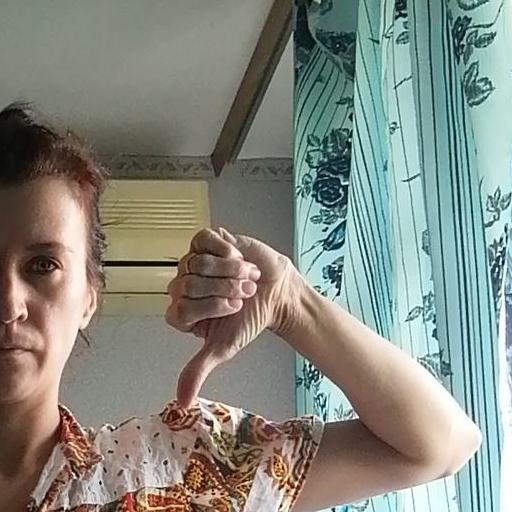

In [ ]:
# Select a random image path from the list of image paths
img_path = random.choice(img_paths)

# Print the name of the class of the image, which is the name of the parent folder
print(f"Class: {img_path.parent.name}")

# Open the image using the path
sample_img = Image.open(img_path)

# Display the image
sample_img

**Data Transformation**

In [ ]:
norm_stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
norm_stats

((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

In [ ]:
# ensure the image transforming into appropriate size for model
train_sz = (288,288)

In [ ]:
# Shuffle the image paths
random.shuffle(img_paths)

# Define the percentage of the images that should be used for training
train_pct = 0.9
val_pct = 0.1

# Calculate the index at which to split the subset of image paths into training and validation sets
train_split = int(len(img_paths)*train_pct)
val_split = int(len(img_paths)*(train_pct+val_pct))

# Split the subset of image paths into training and validation sets
train_paths = img_paths[:train_split]
val_paths = img_paths[train_split:]

# Print the number of images in the training and validation sets
len(train_paths), len(val_paths)

(138361, 15374)

In [ ]:
class ResizePad(nn.Module):
    def __init__(self, max_sz=256, padding_mode='edge'):
        """
        A PyTorch module that resizes an image tensor and adds padding to make it a square tensor.

        Args:
        max_sz (int, optional): The size of the square tensor.
        padding_mode (str, optional): The padding mode used when adding padding to the tensor.
        """
        super().__init__()
        self.max_sz = max_sz
        self.padding_mode = padding_mode

    def forward(self, x):
        # Get the width and height of the image tensor
        w, h = TF.get_image_size(x)

        # Resize the image tensor so that its minimum dimension is equal to `max_sz`
        size = int(min(w, h) / (max(w, h) / self.max_sz))
        x = TF.resize(x, size=size)

        # Add padding to make the image tensor a square
        w, h = TF.get_image_size(x)
        offset = (self.max_sz - min(w, h)) // 2
        padding = [0, offset] if h < w else [offset, 0]
        x = TF.pad(x, padding=padding, padding_mode=self.padding_mode)
        x = TF.resize(x, size=[self.max_sz] * 2)

        return x

Source image: (512, 512)
Cropped image: (512, 256)
Cropped tensor: torch.Size([1, 3, 256, 512])
Padded tensor: torch.Size([1, 3, 288, 288])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


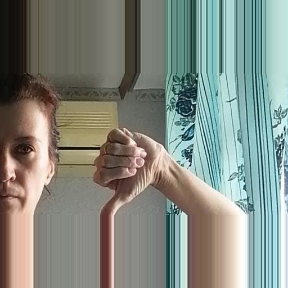

In [ ]:
# sample image
print(f"Source image: {sample_img.size}")

# Crop the source image
w, h = sample_img.size
cropped_img = sample_img.crop([0, h//4, w, h-h//4])
print(f"Cropped image: {cropped_img.size}")

# Create a `ResizePad` object
resize_pad = ResizePad(max_sz=max(train_sz))

# Convert the cropped image to a tensor
img_tensor = transforms.PILToTensor()(cropped_img)[None]
print(f"Cropped tensor: {img_tensor.shape}")

# Resize and pad the tensor
resized_tensor = resize_pad(img_tensor)
print(f"Padded tensor: {resized_tensor.shape}")

# Apply random pixel copy to the resized and padded tensor
tensor_to_pil(resized_tensor)

In [ ]:
train_tfms = [
    ResizePad(max_sz=max(train_sz)),
#     transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(*norm_stats),
#     rand_square_copy_tf,
#     rand_pixel_copy_tf,
#     rand_square_pixel_copy_tf
]
valid_tfms = [
    ResizePad(max_sz=max(train_sz)),
    transforms.ToTensor(),
    transforms.Normalize(*norm_stats),
]

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, img_paths, classes, tfms):
        # Store the arguments as instance variables
        self.img_paths = img_paths
        self.classes = classes
        self.tfms = tfms

        # Create a mapping from class names to class indices
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

    def __len__(self):
        # Return the number of images in the dataset
        return len(self.img_paths)

    def __getitem__(self, index):
        # Get the path of the image at the given index
        img_path = self.img_paths[index]

        # Get the label of the image
        label = self.class_to_idx[img_path.parent.name]

        # Open the image
        image = Image.open(img_path).convert('RGB')

        return self.tfms(image), label

In [ ]:
# create the training dataset using the composed transformations
train_dataset = ImageDataset(img_paths=train_paths,
                             classes=class_names,
                             tfms=transforms.Compose(train_tfms))

# create the validation dataset
valid_dataset = ImageDataset(img_paths=val_paths,
                             classes=class_names,
                             tfms=transforms.Compose(valid_tfms))

# print the length of the training and validation datasets
len(train_dataset), len(valid_dataset)

(138361, 15374)

In [ ]:
# create the training dataset using the composed transformations
train_dataset = ImageDataset(img_paths=train_paths,
                             classes=class_names,
                             tfms=transforms.Compose(train_tfms))

# create the validation dataset
valid_dataset = ImageDataset(img_paths=val_paths,
                             classes=class_names,
                             tfms=transforms.Compose(valid_tfms))

# print the length of the training and validation datasets
len(train_dataset), len(valid_dataset)

(138361, 15374)

In [ ]:
from torch.utils.data import Subset
subset_indices = torch.randperm(len(train_dataset))[:100000]
subset_train_dataset = Subset(train_dataset, subset_indices)

subset_indices = torch.randperm(len(valid_dataset))[:10000]
subset_valid_dataset = Subset(valid_dataset, subset_indices)

In [ ]:
bs = 64 # batch size
train_dataloader = DataLoader(subset_train_dataset,
                              batch_size=bs,
                              shuffle=True,
                              num_workers=multiprocessing.cpu_count())

valid_dataloader = DataLoader(subset_valid_dataset, batch_size=bs)


# Print the number of batches in the training and validation dataloaders
len(train_dataloader), len(valid_dataloader)

(1563, 157)

**Baseline Model - ResNet18**

In [ ]:
torch.cuda.empty_cache()

In [ ]:
num_classes = 19
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model=models.resnet18(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.9)

def train_one_epoch(epoch_index, tb_writer):
  #device = device or torch.device("cpu")
  running_loss = 0.
  last_loss = 0.
  i=0

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting


  model.train()
  for i, data in enumerate(train_dataloader):
  #for images, labels in train_dataloader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

        # Gather data and report
    running_loss += loss.item()
    if i % 100 == 99:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_dataloader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

  return last_loss

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.
# train_loss_history
train_loss_hist = []
# validation_loss_history
val_loss_hist = []

for epoch in range(EPOCHS):
    all_predictions = []
    all_labels = []
    loss_history_epoch = []
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(valid_dataloader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss
            all_predictions.extend(torch.argmax(voutputs, dim=1).cpu().numpy())
            all_labels.extend(vlabels.cpu().numpy())


    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    accuracy = (torch.tensor(all_predictions) == torch.tensor(all_labels)).float().mean().item()
    print('test accuracy: ',accuracy)

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    train_loss_hist.append(avg_loss)
    val_loss_hist.append(avg_vloss)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 100 loss: 0.28538217282295225
  batch 200 loss: 0.26704078578948975
  batch 300 loss: 0.2580287458896637
  batch 400 loss: 0.24314788341522217
  batch 500 loss: 0.21972992062568664
  batch 600 loss: 0.20858781015872954
  batch 700 loss: 0.1819543068408966
  batch 800 loss: 0.16196931993961333
  batch 900 loss: 0.13948841249942778
  batch 1000 loss: 0.1210863596200943
  batch 1100 loss: 0.10348283392190934
  batch 1200 loss: 0.09260382890701294
  batch 1300 loss: 0.0835469685792923
  batch 1400 loss: 0.07335226225852966
  batch 1500 loss: 0.06658849969506264
LOSS train 0.06658849969506264 valid 0.7554774284362793
test accuracy:  0.7656000256538391
EPOCH 2:
  batch 100 loss: 0.055512484192848204
  batch 200 loss: 0.054904685616493226
  batch 300 loss: 0.05099129244685173
  batch 400 loss: 0.048437032029032705
  batch 500 loss: 0.04379403057694435
  batch 600 loss: 0.042543033093214035
  batch 700 loss: 0.0415599350631237
  batch 800 loss: 0.038624422952532766
  batch 900

**Training Loss Visualization**

In [ ]:
print(type(val_loss_hist[0]))
print(type(train_loss_hist[0]))

<class 'torch.Tensor'>
<class 'float'>


In [ ]:
val_loss_hist_cpu = [tensor.cpu() for tensor in val_loss_hist]

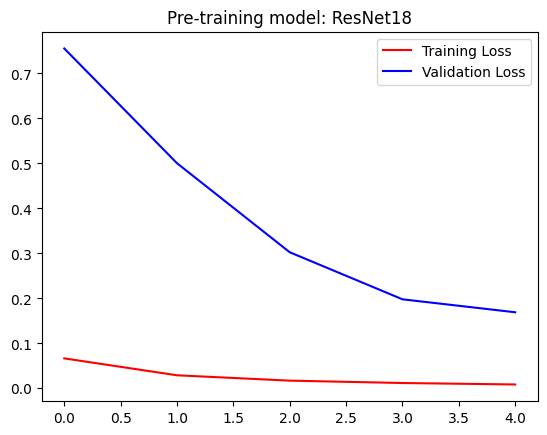

In [ ]:
import matplotlib.pyplot as plt
plt.title('Original trained model: ResNet18')
plt.plot(train_loss_hist, 'r', label = 'Training Loss')
plt.plot(val_loss_hist_cpu, 'b', label = 'Validation Loss')
plt.legend()

**Saving Model**

In [ ]:
torch.save(model.state_dict(), '/content/ResNet18.pth')

**Validating Model**

In [ ]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Validating Subeset Data**

In [ ]:
model.load_state_dict(torch.load('/content/ResNet18.pth'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model.to(device)
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, labels in valid_dataloader:
        # Move data to device if using GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Append predictions and labels to the lists
        all_predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy, precision, recall, or any other metric as needed
accuracy = (torch.tensor(all_predictions) == torch.tensor(all_labels)).float().mean().item()

In [ ]:
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.9510999917984009


**Data Augmented Dataset**

In [ ]:
# same dataset, but saving in /content/
# Define path to store datasets
dataset_dir = Path("/content/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)
print(f"Dataset Directory: {dataset_dir}")

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)
print(f"Archive Directory: {archive_dir}")

Dataset Directory: /content
Archive Directory: /content/../Archive


In [ ]:
# Set the name of the dataset
dataset_name = 'hagrid-classification-512p-no-gesture-150k'

# Construct the Kaggle dataset name by combining the username and dataset name
kaggle_dataset = f'innominate817/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')
print(f"Archive Path: {archive_path}")

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')
print(f"Dataset Path: {dataset_path}")

Archive Path: /content/../Archive/hagrid-classification-512p-no-gesture-150k.zip
Dataset Path: /content/hagrid-classification-512p-no-gesture-150k


In [ ]:
dl_kaggle(kaggle_dataset, archive_path, dataset_path)

100%|██████████| 3.55G/3.55G [02:02<00:00, 31.2MB/s]


In [ ]:
# Get all subfolders within the dataset_path
folders = [folder for folder in dataset_path.glob('*/') if folder.is_dir()]

# Store the folder names
class_names = [f.name for f in folders]

# Print the list of class names
pd.DataFrame(class_names)

,0
0,three
1,four
2,peace
3,one
4,peace_inverted
5,stop
6,call
7,no_gesture
8,three2
9,mute


In [ ]:
# Get a list of all image file paths from the given folders
img_paths = [get_img_files(folder) for folder in folders]

# Flatten the list of lists into a single list
img_paths = [path for class_paths in img_paths for path in class_paths]

# Get the number of image file paths
len(img_paths)

153735

**Augment Techniques**

*Method rand_pixel_copy*

In [ ]:
def rand_pixel_copy(img_tensor:torch.Tensor, pct:float=0.2):
    """
    Copy data from a randomly selected set of pixels to another randomly selected set of pixels of a image tensor.

    Args:
    img_tensor (torch.Tensor): The input image tensor.
    pct (float, optional): The percentage of the total number of pixels to be selected as the source and target sets
                           of pixels.

    Returns:
    torch.Tensor: The modified input image tensor.
    """

    src_dim = img_tensor.dim()

    img_tensor = img_tensor.unsqueeze(0) if src_dim == 3 else img_tensor

    # Get the shape of the img_tensor
    b, c, h, w = img_tensor.shape

    # Calculate the number of pixels to be selected
    num_pixels = int(img_tensor[-1:].numel() * pct)

    # Select the source pixel indices
    source_indices = torch.LongTensor(num_pixels, 2).random_(0, h * w)
    source_indices[:, 0] = source_indices[:, 0] // w
    source_indices[:, 1] = source_indices[:, 1] % w

    # Select the target pixel indices
    target_indices = torch.LongTensor(num_pixels, 2).random_(0, h * w)
    target_indices[:, 0] = target_indices[:, 0] // w
    target_indices[:, 1] = target_indices[:, 1] % w

    # Get the indices of the channels
    c_indices = torch.arange(c).repeat(num_pixels, 1).t()

    # Copy the pixels
    source_pixels = img_tensor[:, c_indices, source_indices[:, 0], source_indices[:, 1]]
    img_tensor[:, c_indices, target_indices[:, 0], target_indices[:, 1]] = source_pixels

    return img_tensor.squeeze(0) if src_dim == 3 else img_tensor

In [ ]:
class RandPixelCopy(nn.Module):
    def __init__(self, pct=0.1):
        """
        A PyTorch module that applies the `rand_pixel_copy` function to an input tensor.

        Args:
        pct (float, optional): The maximum percentage of the tensor's pixels to be copied.
        """
        super().__init__()
        self.pct = pct

    def forward(self, x):
        # Apply the `rand_pixel_copy` function to the input tensor
        return rand_pixel_copy(x, max(0.0025, random.random() * self.pct))

*Random Square Pixel Copy Transform*

In [ ]:
def rand_square_pixel_copy(img_tensor:torch.Tensor, square_pct:float, pixel_pct:float):
    """
    Copy data from a randomly selected set of pixels of a randomly selected square region to another randomly
    selected square region of a tensor.

    Args:
    img_tensor (torch.Tensor): The input tensor.
    square_pct (float): The percentage of the tensor's size to be used as the side length of the square regions.
    pixel_pct (float): The percentage of the pixels of the source square region to be copied.

    Returns:
    torch.Tensor: The modified input tensor.
    """
    # Get the shape of the tensor
    h, w = img_tensor.shape[-2:]

    # Calculate the size of the square
    szx = int(square_pct * h)
    szy = int(square_pct * w)

    # Calculate the top-left coordinate of the first square
    stx1 = int(random.random() * (1 - square_pct) * h)
    sty1 = int(random.random() * (1 - square_pct) * w)

    # Calculate the top-left coordinate of the second square
    stx2 = int(random.random() * (1 - square_pct) * h)
    sty2 = int(random.random() * (1 - square_pct) * w)

    # Copy the data from the second square to the first square
    source_pixels = rand_pixel_copy(img_tensor[..., stx2:stx2 + szx, sty2:sty2 + szy].clone(), pixel_pct)
    img_tensor[..., stx1:stx1 + szx, sty1:sty1 + szy] = source_pixels

    # Return the modified input tensor
    return img_tensor

In [ ]:
class RandSquarePixelCopy(nn.Module):
    def __init__(self, square_pct=0.2, pixel_pct=1.0, min_num=0, max_num=4):
        """
        A PyTorch module that applies the `rand_square_pixel_copy` function to an input tensor.

        Args:
        square_pct (float, optional): The percentage of the tensor's size to be used as the side length of the
                                      square regions.
        pixel_pct (float, optional): The maximum percentage of the pixels of the source square region to be copied.
        min_num (int, optional): The minimum number of times the `rand_square_pixel_copy` function is applied to
                                 the input tensor.
        max_num (int, optional): The maximum number of times the `rand_square_pixel_copy` function is applied to
                                 the input tensor.
        """
        super().__init__()
        self.square_pct = square_pct
        self.pixel_pct = pixel_pct
        self.min_num = min_num
        self.max_num = max_num

    def forward(self, x):
        # Apply the `rand_square_pixel_copy` function to the input tensor
        for i in range(random.randint(self.min_num, self.max_num)):
            x = rand_square_pixel_copy(x,
                                       max(0.1,random.random()*self.square_pct),
                                       max(0.0025, random.random()*self.pixel_pct))
        return x

**Entire Dataset with Augmentation**

torch.Size([3, 512, 512])


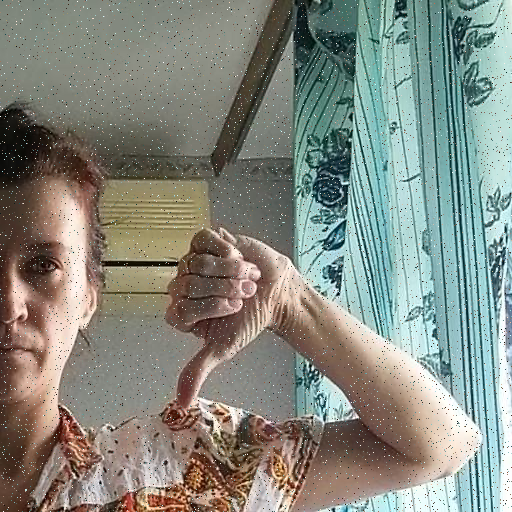

In [ ]:
rand_pixel_copy_tf = RandPixelCopy(pct=0.015)

# Convert the PIL image to a tensor
img_tensor = transforms.PILToTensor()(sample_img)
print(img_tensor.shape)

# Apply the `rand_pixel_copy_tf` transform to the image tensor
tensorImg = transforms.ToPILImage()(rand_pixel_copy_tf(img_tensor))
display(tensorImg)

torch.Size([3, 512, 512])


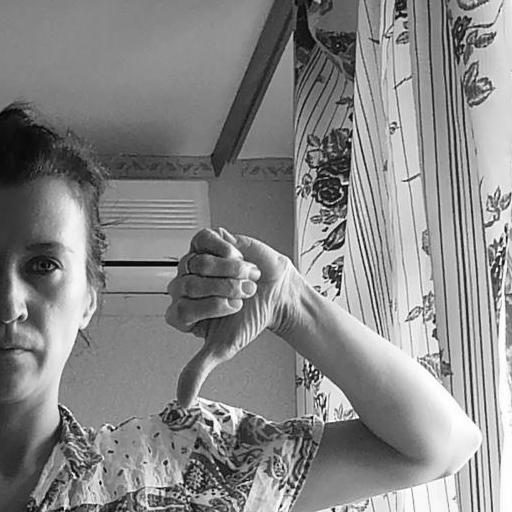

In [ ]:
from torchvision.transforms import v2
from torchvision.transforms import functional as F
img_tensor = transforms.PILToTensor()(sample_img)
print(img_tensor.shape)
tensorImage = F.to_grayscale(sample_img)
display(tensorImage)

torch.Size([3, 512, 512])


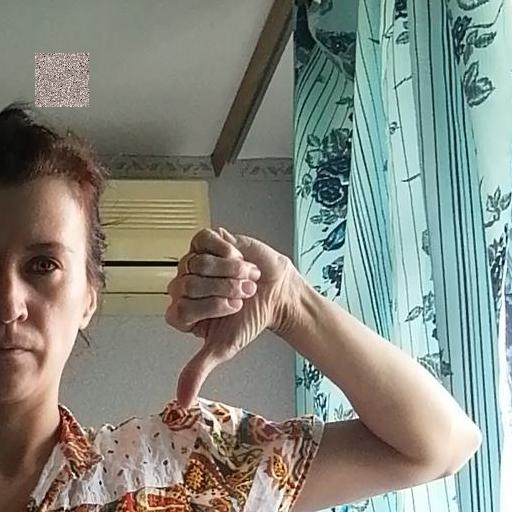

In [ ]:
rand_square_pixel_copy_tf = RandSquarePixelCopy(square_pct=0.2, pixel_pct=1.0, min_num=1, max_num=1)

img_tensor = transforms.PILToTensor()(sample_img)
print(img_tensor.shape)

tensor_to_pil(rand_square_pixel_copy_tf(img_tensor))

In [ ]:
from torchvision.transforms import functional as F
from torchvision.transforms import ToPILImage, ToTensor
from PIL import Image
import os

def augment_and_save(base_path, augmentations, class_names):
    for class_name in class_names:
        class_folder = os.path.join(base_path, class_name)

        if not os.path.isdir(class_folder):
            print(f"Class folder not found or not a directory: {class_folder}")
            continue

        for image_file in os.listdir(class_folder):
            if not image_file.lower().endswith(('.png', '.jpg', '.jpeg')) or '_' in image_file:
                continue

            image_path = os.path.join(class_folder, image_file)
            image = Image.open(image_path)
            original_name = os.path.splitext(image_file)[0]

            for aug_name, aug_function in augmentations.items():
                if aug_function == F.to_grayscale:
                    augmented_image = aug_function(image)
                else:
                    img_tensor = ToTensor()(image)
                    augmented_image_tensor = aug_function(img_tensor)
                    augmented_image = ToPILImage()(augmented_image_tensor)

                save_path = os.path.join(class_folder, f"{original_name}_{aug_name}.jpg")
                augmented_image.save(save_path)


augmentations = {
    "square": rand_square_pixel_copy_tf,
    "blur": rand_pixel_copy_tf,
    "grey": F.to_grayscale,
}

base_path = '/content/hagrid-classification-512p-no-gesture-150k'
augment_and_save(base_path, augmentations, class_names)

In [ ]:
# Get a list of all image file paths from the given folders
img_paths = [get_img_files(folder) for folder in folders]

# Flatten the list of lists into a single list
img_paths = [path for class_paths in img_paths for path in class_paths]

# Get the number of image file paths
len(img_paths)

614940

**Dataloader**

In [ ]:
train_sz = (288,288)

In [ ]:
import torchvision.transforms.functional as TF

In [ ]:
# Shuffle the image paths
random.shuffle(img_paths)

# Split the subset of image paths into training and validation sets
train_paths = img_paths[:90000] # 90,000 training images
val_paths = img_paths[90000:99000] #9,000 validation images

# Print the number of images in the training and validation sets
len(train_paths), len(val_paths)

(90000, 9000)

In [ ]:
# create the training dataset using the composed transformations
train_dataset = ImageDataset(img_paths=train_paths,
                             classes=class_names,
                             tfms=transforms.Compose(train_tfms))

# create the validation dataset
valid_dataset = ImageDataset(img_paths=val_paths,
                             classes=class_names,
                             tfms=transforms.Compose(valid_tfms))

# print the length of the training and validation datasets
len(train_dataset), len(valid_dataset)

(90000, 9000)

In [ ]:
bs = 64 # batch size
train_dataloader = DataLoader(train_dataset,
                              batch_size=bs,
                              shuffle=True,
                              num_workers=multiprocessing.cpu_count())

valid_dataloader = DataLoader(valid_dataset, batch_size=bs)


# Print the number of batches in the training and validation dataloaders
len(train_dataloader), len(valid_dataloader)

(1407, 141)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model.to(device)
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, labels in valid_dataloader:
        # Move data to device if using GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Append predictions and labels to the lists
        all_predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy, precision, recall, or any other metric as needed
accuracy = (torch.tensor(all_predictions) == torch.tensor(all_labels)).float().mean().item()

In [ ]:
print(f"Test Accuracy with Augmented Validation Dataset: {accuracy}")

Test Accuracy with Augmented Validation Dataset: 0.9347777962684631


**Augmented Dataset Training with ResNet18**

In [ ]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.
# train_loss_history
train_loss_hist = []
# validation_loss_history
val_loss_hist = []

for epoch in range(EPOCHS):
    all_predictions = []
    all_labels = []
    loss_history_epoch = []
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(valid_dataloader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss
            all_predictions.extend(torch.argmax(voutputs, dim=1).cpu().numpy())
            all_labels.extend(vlabels.cpu().numpy())


    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    accuracy = (torch.tensor(all_predictions) == torch.tensor(all_labels)).float().mean().item()
    print('test accuracy: ',accuracy)

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    train_loss_hist.append(avg_loss)
    val_loss_hist.append(avg_vloss)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 100 loss: 0.021648107234388588
  batch 200 loss: 0.018807318896055223
  batch 300 loss: 0.01827058367803693
  batch 400 loss: 0.0182230989895761
  batch 500 loss: 0.01612891854252666
  batch 600 loss: 0.01587068349123001
  batch 700 loss: 0.016529535621404648
  batch 800 loss: 0.0169360129237175
  batch 900 loss: 0.01525907287746668
  batch 1000 loss: 0.014837149006314576
  batch 1100 loss: 0.014575722359120845
  batch 1200 loss: 0.015422125102952123
  batch 1300 loss: 0.012419915113598108
  batch 1400 loss: 0.013835582319647073
LOSS train 0.013835582319647073 valid 0.19485582411289215
test accuracy:  0.9381111264228821
EPOCH 2:
  batch 100 loss: 0.009460348330438137
  batch 200 loss: 0.007943613505922258
  batch 300 loss: 0.007507878363132477
  batch 400 loss: 0.008014777397271246
  batch 500 loss: 0.008427994161844253
  batch 600 loss: 0.007519201599061489
  batch 700 loss: 0.007661999306641519
  batch 800 loss: 0.008328218089416623
  batch 900 loss: 0.00822859705612

**Augmented Dataset Visualization in Training Loss & Validation Loss**

In [ ]:
val_loss_hist_cpu = [tensor.cpu() for tensor in val_loss_hist]

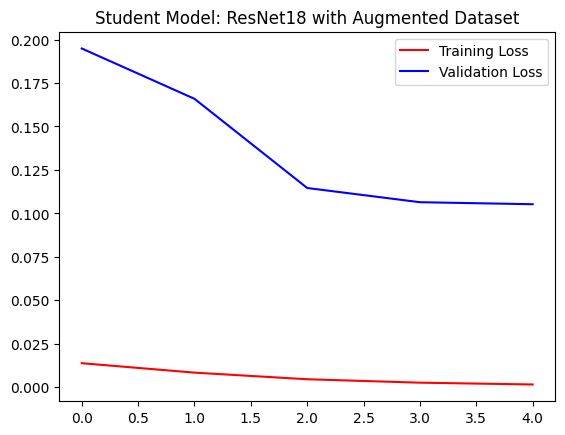

In [ ]:
import matplotlib.pyplot as plt
plt.title('Student Model: ResNet18 with Augmented Dataset')
plt.plot(train_loss_hist, 'r', label = 'Training Loss')
plt.plot(val_loss_hist_cpu, 'b', label = 'Validation Loss')
plt.legend()

**Augmented Sample - Image Printout with Predicted Labels & Actual Label**

Class: stop
Predicted Class: stop


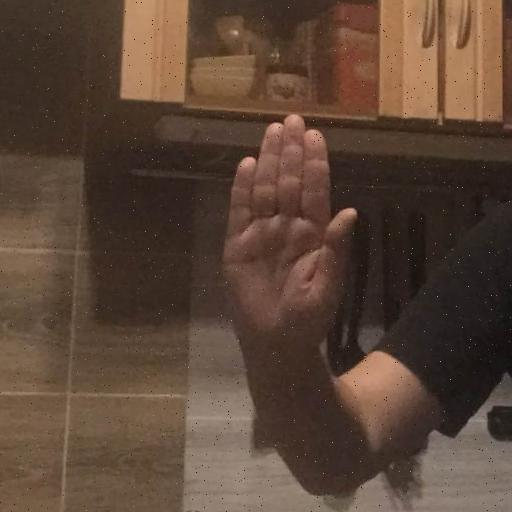

In [ ]:
model = model.to('cuda')

infer_sz = max(train_sz)

# Choose a random image from the list of image paths
img_path = random.choice(img_paths)

# Print the actual class of the chosen image
print(f"Class: {img_path.parent.name}")

# Open the image and resize it
sample_img = Image.open(img_path)
inp_img = resize_img(sample_img.copy(), infer_sz)

# Convert the image to a tensor and move it to the device
img_tensor = pil_to_tensor(inp_img)
img_tensor = img_tensor.to('cuda')

# Make a prediction with the model
with torch.no_grad():
    pred = model(img_tensor)

# Get the predicted class index and convert it to the class name
pred_class = train_dataset.classes[torch.argmax(torch.softmax(pred, dim=1))]

# Print the predicted class
print(f"Predicted Class: {pred_class}")

# Display the image
sample_img